In [1]:
import impact
import csvv
import xarray as xr
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from visualize import plot_by_hierid
#This is our base impact class here
from impact import PolynomialImpact

import impact


In [2]:
#Initialize our impact obj
#The main implementation difference for PolynomialImpact is that we use findpolymins to get t_star
#https://github.com/ClimateImpactLab/impact-common/blob/master/impactcommon/math/minpoly.py
#Code is from here for findpolymins. We simply use np.apply_along_axis to apply this function to betas matrix
impact_PI = PolynomialImpact()


In [3]:
#set up for weather IO
#GCM: ACCESS1-0
#model run: rcp85
#year: 2099
path = '/shares/gcp/climate/BCSD/hierid/popwt/daily/{pred}/{rcp}/{model}/{year}/1.5.nc4'
metadata = {'year': 2099, 'rcp': 'rcp85', 'model': 'ACCESS1-0'}
prednames = ['tas', 'tas-poly-2', 'tas-poly-3', 'tas-poly-4']
weathers = {k:str(path) for k in prednames}
weathers = {k:str(v.format(pred=k, **metadata)) for k, v in weathers.items()}


In [4]:
#we use this to map the construction of weather datarrays
weathers

{'tas': '/shares/gcp/climate/BCSD/hierid/popwt/daily/tas/rcp85/ACCESS1-0/2099/1.5.nc4',
 'tas-poly-2': '/shares/gcp/climate/BCSD/hierid/popwt/daily/tas-poly-2/rcp85/ACCESS1-0/2099/1.5.nc4',
 'tas-poly-3': '/shares/gcp/climate/BCSD/hierid/popwt/daily/tas-poly-3/rcp85/ACCESS1-0/2099/1.5.nc4',
 'tas-poly-4': '/shares/gcp/climate/BCSD/hierid/popwt/daily/tas-poly-4/rcp85/ACCESS1-0/2099/1.5.nc4'}

In [5]:
#do the weather thing
weather_bcsd = impact.construct_weather(weathers, metadata)

In [6]:
#did that work?
weather_bcsd

<xarray.DataArray 'tas-poly-4' (prednames: 4, time: 365, hierid: 24378)>
array([[[  8.931631e+05,   3.242649e+03, ...,   1.193613e+06,   7.980340e+05],
        [  8.852571e+05,   8.944390e+03, ...,   1.205488e+06,   8.296621e+05],
        ..., 
        [  7.206342e+05,   2.786553e+03, ...,   1.027303e+06,   7.291900e+05],
        [  7.094678e+05,   4.085975e+03, ...,   1.035973e+06,   8.157897e+05]],

       [[  9.449608e+02,   4.757939e+01, ...,   1.092071e+03,   8.902645e+02],
        [  9.407950e+02,   8.698185e+01, ...,   1.097684e+03,   9.080014e+02],
        ..., 
        [  8.488292e+02,   4.418794e+01, ...,   1.013244e+03,   8.516277e+02],
        [  8.422253e+02,   5.579747e+01, ...,   1.017149e+03,   9.007885e+02]],

       [[  2.905088e+04,  -3.793118e+02, ...,   3.610039e+04,   2.663164e+04],
        [  2.885840e+04,  -8.649584e+02, ...,   3.637424e+04,   2.742538e+04],
        ..., 
        [  2.473194e+04,  -3.415143e+02, ...,   3.226060e+04,   2.490303e+04],
        [  2

In [7]:
#setup for covars io
covarnames = ['loggdppc', 'climtas']
gdp_path = '/shares/gcp/compute_demo/covars/2099/{covarname}.nc'
clim_path = '/shares/gcp/compute_demo/covars/2099/{covarname}.nc'
covars  = {k:str(gdp_path.format(covarname=k)) for k in covarnames}

In [8]:
xr.open_dataset('/shares/gcp/compute_demo/covars/2099/climtas.nc')

<xarray.Dataset>
Dimensions:  (hierid: 24378)
Coordinates:
  * hierid   (hierid) |S35 'ABW' 'AFG.1.12' 'AFG.1.R8abddb145b8788ee' ...
Data variables:
    climtas  (hierid) float64 29.88 4.462 14.79 10.34 16.4 6.13 8.849 27.24 ...
Attributes:
    kernel:        30
    description:   annual kernelized gdppc by hierid
    created:       2017-08-22 16:23:11.529019
    author:        Justin Simcock
    rcp:           rcp85
    project:       gcp
    source:        climate_covars.py
    contact:       jsimcock@rhg.com
    version:       0.1.1
    year:          2099
    variable:      tas
    dependencies:  /global/scratch/mdelgado/projection/gcp/climate/hierid/pop...
    model:         ACCESS1-0

In [9]:
covars = impact.construct_covars(covars)

In [10]:
covars

<xarray.DataArray 'loggdppc' (covarnames: 3, hierid: 24378)>
array([[       nan,        nan,        nan, ...,  10.356662,  10.35576 ,
         10.354137],
       [ 29.881263,   4.461913,  14.79369 , ...,  26.846338,  28.970277,
         27.116949],
       [  1.      ,   1.      ,   1.      , ...,   1.      ,   1.      ,   1.      ]])
Coordinates:
  * hierid      (hierid) object 'ABW' 'AFG.1.12' 'AFG.1.R8abddb145b8788ee' ...
  * covarnames  (covarnames) object 'loggdppc' 'climtas' '1'

In [11]:
#gammas set-up
gammas = csvv.get_gammas('/shares/gcp/compute_demo/global_interaction_Tmean-POLY-4-AgeSpec.csvv')

gm = gammas.median()


In [12]:
#this is our median set of gammas
gm

<xarray.DataArray (outcome: 3, prednames: 4, covarnames: 3)>
array([[[ -4.337158e-02,  -2.119506e-03,   7.634971e-03],
        [ -1.156127e-03,  -2.243829e-04,   1.489550e-04],
        [ -4.227101e-04,   1.490188e-05,   3.218977e-05],
        [  1.399401e-05,  -2.273452e-07,  -1.178488e-06]],

       [[  1.408138e-01,   2.914281e-03,  -1.619050e-02],
        [ -6.782383e-03,  -2.052364e-05,   6.804187e-04],
        [ -6.373995e-05,  -4.705649e-06,   9.215832e-06],
        [  5.642453e-06,   9.074323e-08,  -5.820008e-07]],

       [[  6.368397e+00,   5.945595e-02,  -6.973708e-01],
        [ -2.364590e-01,   1.066041e-03,   2.170100e-02],
        [ -6.407747e-03,  -1.300569e-04,   7.485756e-04],
        [  2.770347e-04,   1.774457e-06,  -2.785893e-05]]])
Coordinates:
  * outcome     (outcome) object 'age0-4' 'age5-64' 'age65+'
  * prednames   (prednames) object 'tas' 'tas-poly-2' 'tas-poly-3' 'tas-poly-4'
  * covarnames  (covarnames) object '1' 'climtas' 'loggdppc'

In [13]:
#Ok now some betas
betas = (gm*covars).sum(dim='covarnames')
betas

<xarray.DataArray (outcome: 3, prednames: 4, hierid: 24378)>
array([[[ -1.067051e-01,  -5.282863e-02, ...,  -2.570833e-02,  -2.179259e-02],
        [ -7.860971e-03,  -2.157304e-03, ...,  -6.114019e-03,  -5.698405e-03],
        [  2.257676e-05,  -3.562192e-04, ...,   3.423509e-04,   3.146805e-04],
        [  7.200646e-06,   1.297961e-05, ...,  -4.796381e-06,  -4.373123e-06]],

       [[  2.278962e-01,   1.538171e-01, ...,   5.757646e-02,   5.220162e-02],
        [ -7.395656e-03,  -6.873958e-03, ...,  -3.307059e-04,  -2.937732e-04],
        [ -2.043507e-04,  -8.473615e-05, ...,  -1.046269e-04,  -9.592079e-05],
        [  8.353976e-06,   6.047342e-06, ...,   2.244249e-06,   2.077017e-06]],

       [[  8.145015e+00,   6.633684e+00, ...,   8.690470e-01,   7.599875e-01],
        [ -2.046043e-01,  -2.317024e-01, ...,   1.915485e-02,   1.714391e-02],
        [ -1.029401e-02,  -6.988050e-03, ...,  -2.423462e-03,  -2.183639e-03],
        [  3.300577e-04,   2.849521e-04, ...,   3.994076e-05,   3.

In [14]:
#let's generate some synthetic weather now
#this is lots of xarray syntax. If this is confusing let us know

tasvals = np.linspace(-10, 40, 100)
tas = xr.DataArray(tasvals, dims=('sample',), coords={'sample': tasvals})
weather_synth = xr.concat(
    [tas**i for i in range(1,5)],
    dim=pd.Index(['tas'] + ['tas-poly-{}'.format(i) for i in range(2,5)], name='prednames'))

In [15]:
#What does this look like?
weather_synth

<xarray.DataArray (prednames: 4, sample: 100)>
array([[ -1.000000e+01,  -9.494949e+00,  -8.989899e+00, ...,   3.898990e+01,
          3.949495e+01,   4.000000e+01],
       [  1.000000e+02,   9.015407e+01,   8.081828e+01, ...,   1.520212e+03,
          1.559851e+03,   1.600000e+03],
       [ -1.000000e+03,  -8.560083e+02,  -7.265482e+02, ...,   5.927292e+04,
          6.160624e+04,   6.400000e+04],
       [  1.000000e+04,   8.127756e+03,   6.531595e+03, ...,   2.311045e+06,
          2.433135e+06,   2.560000e+06]])
Coordinates:
  * sample     (sample) float64 -10.0 -9.495 -8.99 -8.485 -7.98 -7.475 -6.97 ...
  * prednames  (prednames) object 'tas' 'tas-poly-2' 'tas-poly-3' 'tas-poly-4'

In [16]:
#Calculate the impact with synethic weather
impacts = (betas*weather_synth).sum(dim='prednames')


In [23]:
impacts

<xarray.DataArray (outcome: 3, hierid: 24378, sample: 100)>
array([[[   0.330384,    0.34366 , ...,    2.434759,    3.032809],
        [   0.798571,    0.717537, ...,    4.184286,    4.864943],
        ..., 
        [  -0.744633,   -0.639143, ...,   -1.131603,   -1.179044],
        [  -0.710326,   -0.611728, ...,   -1.003476,   -1.044792]],

       [[  -2.730637,   -2.587787, ...,    5.201706,    5.590535],
        [  -2.080357,   -1.958515, ...,    4.846373,    5.212432],
        ..., 
        [  -0.481766,   -0.468698, ...,    0.773016,    0.823082],
        [  -0.434703,   -0.423146, ...,    0.747801,    0.796259]],

       [[ -88.315997,  -84.288033, ...,  171.434407,  184.56467 ],
        [ -79.669505,  -75.577555, ...,  163.395452,  176.865839],
        ..., 
        [  -3.952115,   -4.125537, ...,   12.082567,   12.55641 ],
        [  -3.334872,   -3.50297 , ...,   11.521377,   12.022003]]])
Coordinates:
  * outcome  (outcome) object 'age0-4' 'age5-64' 'age65+'
  * hierid   (hie

A Jupyter Widget

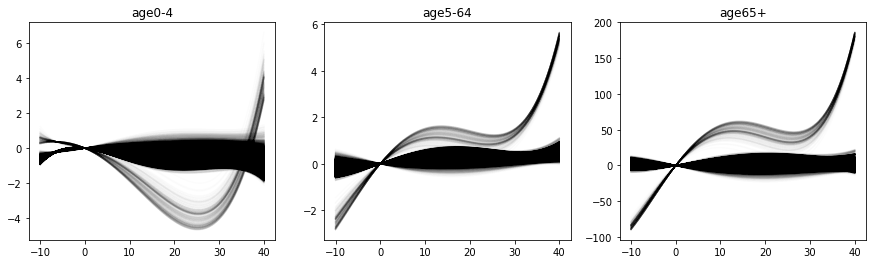

In [18]:
#Ok now we have spaghetti
#Let's plot all those impacts on the 
fig, axes = plt.subplots(1, len(impacts.outcome), figsize=(5*len(impacts.outcome), 4))

#tqdm notebook is our progress bar
for i, out in enumerate(tqdm_notebook(impacts.outcome.values)):
    vals = impacts.sel(outcome=out)
    axes[i].plot(vals.sample.values, vals.values.T, color='black', alpha=0.01)
    axes[i].set_title(out)

    



In [19]:
#this is our mc simulation
samples = []

for i in range(12): 
    gmc = gammas.sample(i)
    betas = (covars*gmc).sum(dim='covarnames')
    t_star = impact_PI.get_t_star(betas, bounds=[10,25], t_star_path='/shares/gcp/compute_demo/t_star/t_star_{}.nc'.format(i))
    val = (impact_PI.compute(weather_bcsd,betas, t_star = t_star))
    
    
    samples.append(val)


/home/jsimcock/miniconda2/envs/py27/lib/python2.7/site-packages/scipy/stats/_multivariate.py:535: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


In [20]:
all_impacts = xr.concat(samples, dim=pd.Index(range(12), name='sample'))

In [21]:
all_impacts

<xarray.DataArray (sample: 12, hierid: 24378, outcome: 3)>
array([[[ -1.295637e+03,   5.555665e+02,   1.907189e+04],
        [ -2.612517e+02,   2.448702e+02,   1.096854e+04],
        ..., 
        [ -2.524465e+02,   1.802723e+02,   4.194871e+03],
        [ -2.317470e+02,   1.637249e+02,   3.658306e+03]],

       [[  1.724050e+06,  -7.509253e+04,  -7.275156e+05],
        [  4.627640e+04,  -8.875204e+03,   1.359973e+04],
        ..., 
        [  2.660611e+06,   5.839274e+05,  -1.173391e+06],
        [  2.047385e+06,   4.616541e+05,  -1.074986e+06]],

       ..., 
       [[ -8.770179e+05,   3.027767e+05,  -1.001072e+06],
        [ -1.149585e+04,   9.453995e+03,  -2.347863e+04],
        ..., 
        [ -1.034530e+06,   6.275163e+05,  -1.040126e+06],
        [ -9.443414e+05,   5.206563e+05,  -9.531924e+05]],

       [[  3.225507e+05,  -1.894011e+05,  -3.915554e+05],
        [  1.990996e+04,  -7.899191e+03,   1.271123e+03],
        ..., 
        [  1.232782e+06,   4.808923e+04,  -6.152648e+0

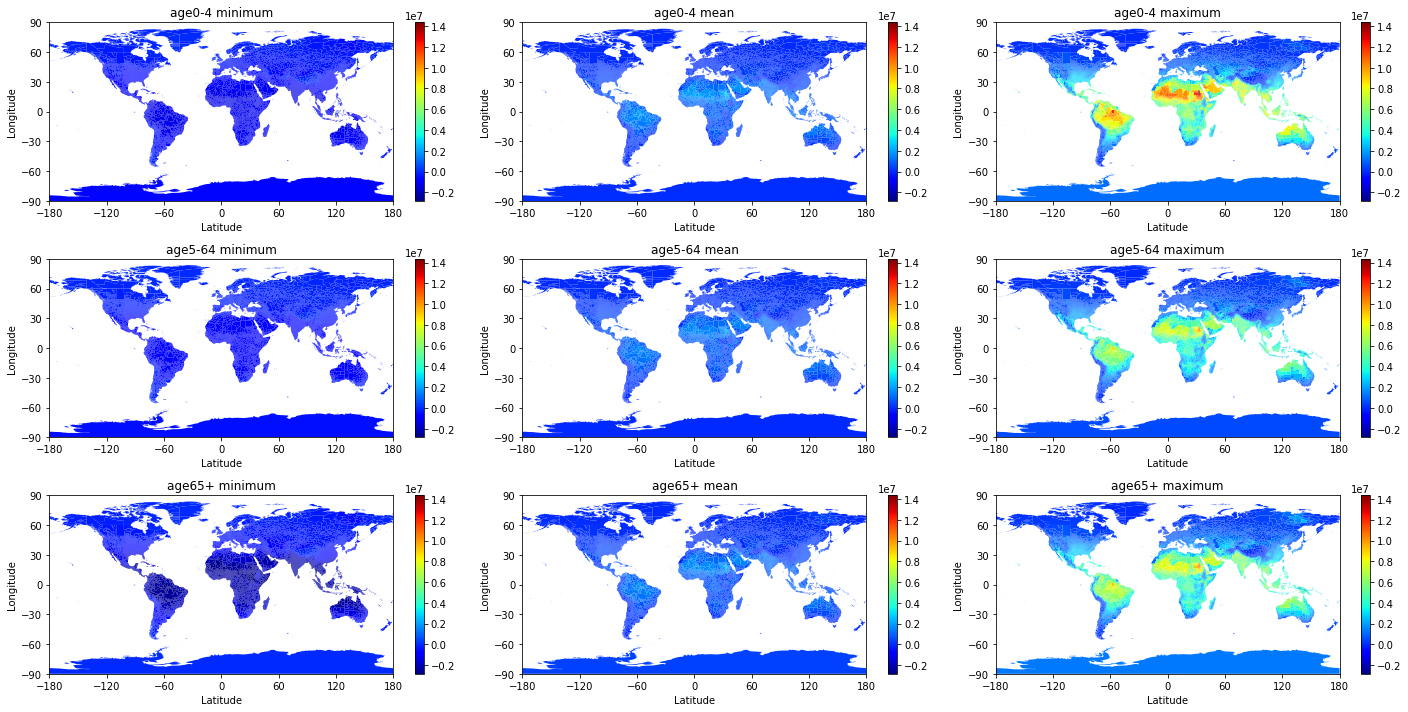

In [22]:
fig, axes = plt.subplots(3, 3, figsize=(20, 10))

yrange = [all_impacts.min(), all_impacts.max()]

for i, out in enumerate(all_impacts.outcome.values):
    
    minimum = all_impacts.sel(outcome=out).min(dim='sample')
    mean = all_impacts.sel(outcome=out).mean(dim='sample')
    maximum = all_impacts.sel(outcome=out).max(dim='sample')
    
    plot_by_hierid(minimum, ax=axes[i, 0], clim=yrange)
    plot_by_hierid(mean, ax=axes[i, 1], clim=yrange)
    plot_by_hierid(maximum, ax=axes[i, 2], clim=yrange)
    
    axes[i, 0].set_title('{} minimum'.format(out))
    axes[i, 1].set_title('{} mean'.format(out))
    axes[i, 2].set_title('{} maximum'.format(out))

plt.tight_layout()

In [25]:
#Lets unravel all the values for tas for every day and every location to see what tas looks like
unravel_bcsd_tas =np.ravel(weather_bcsd.sel(prednames='tas'))

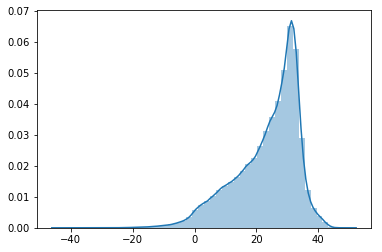

In [26]:
#Lets do some data viz on our temperature dist
#Now let's plot!
#This is so cool!!!
sns.distplot(unravel_bcsd_tas)

In [27]:
x = (covars.sel(covarnames='loggdppc'))
x = x[~np.isnan(x)]

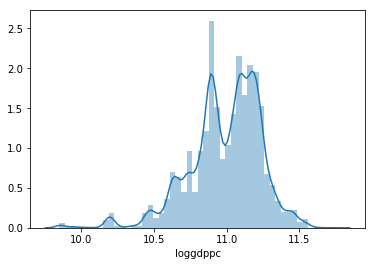

In [28]:
sns.distplot(x)

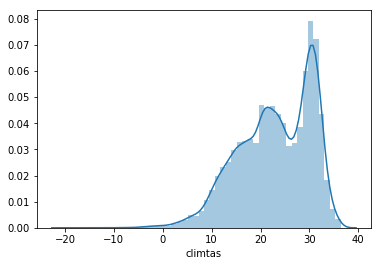

In [29]:
sns.distplot(covars.sel(covarnames='climtas'), axlabel='climtas')